In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [4]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [5]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [6]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [7]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [8]:
filename = "03-table-01-sales-of-saws-for-acme-tool.ods"
df = read_ods(filename, 
  {"t": "t", 
   "Sales": "Y_t"})

num_of_quarters = 24
df_compute = df[:num_of_quarters]   
df_test = df[num_of_quarters:]

df_compute

,t,Y_t
0,1,500
1,2,350
2,3,250
3,4,400
4,5,450
5,6,350
6,7,200
7,8,300
8,9,350
9,10,200


In [9]:
df_test

,t,Y_t
24,25,850
25,26,600
26,27,450
27,28,700


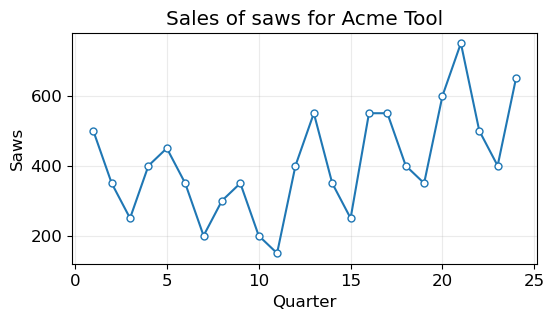

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_compute["t"], df_compute["Y_t"], marker='o', markersize=5, 
  markerfacecolor="white")
ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Sales of saws for Acme Tool")
ax.grid("on")
plt.show(fig)


## Forecasting using Winter's method 
Winter's method = double exponential smoothed values with **seasonal estimate**

The three equations used in Holt's method are
1. The exponentially smoothed series, or current level estimate
$$
  L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1})
$$

2. The trend estimate
$$
  T_t = \beta(L_t - L_{t-1}) + (1 - \beta) T_{t-1}
$$

3. The seasonal estimate
$$
  S_t = \gamma \frac{Y_t}{L_t} + (1 - \gamma) S_{t-s}
$$

4. The forecast for $p$ periods into the future
$$
  \hat{Y}_{t+p} = (L_t + p\,T_t)\, S_{t-s + p}
$$

In the textboook (Example 10), there is no description how
to compute the initial setting for $L_t$, $T_t$ and $S_t$.
Then we use the initial setting of them from Table 9.

In [18]:
df_forecast = df.copy()

Y_t = df_forecast["Y_t"].to_numpy()

alpha = 0.4 
beta = 0.1
gamma = 0.3
p = 1
s = 4

# The initial setting is only for Sales Saw of Acme Tool data
init_L_t = [415.459, 383.109, 358.984, 328.077]
init_T_t = [-41.9541, -40.9937, -39.3068, -38.4668]
init_S_t = [1.26744, 0.89040, 0.66431, 1.18766]

num_of_rows = len(Y_t)
L_t = np.empty(num_of_rows)
T_t = np.empty(num_of_rows)
S_t = np.empty(num_of_rows)
L_t[:4] = init_L_t
T_t[:4] = init_T_t
S_t[:4] = init_S_t

for i in range(4, len(df_forecast)):
  L_t[i] = alpha*Y_t[i]/(S_t[i-s]) + (1 - alpha)*(L_t[i-1] + T_t[i-1]) 
  T_t[i] = beta*(L_t[i] - L_t[i-1]) + (1 - beta) * T_t[i-1]
  S_t[i] = gamma*Y_t[i]/L_t[i] + (1 - gamma)*S_t[i-s]


df_forecast["L_t"] = L_t
df_forecast["T_t"] = T_t
df_forecast["S_t"] = S_t
df_forecast["S_tMsPp"] = df_forecast["S_t"].shift(s).shift(-p)

df_forecast[f"hat_Y_tP{p}"] = ((df_forecast["L_t"] + p*df_forecast["T_t"]) \
  *df_forecast["S_tMsPp"]).shift(p)

df_forecast["e_t"] = df_forecast["Y_t"] - df_forecast[f"hat_Y_tP{p}"]

# Put NaN to the last quarter in 2006
L_t = df_forecast["L_t"].to_numpy()
T_t = df_forecast["T_t"].to_numpy()
S_t = df_forecast["S_t"].to_numpy()

L_t[-4:] = np.NaN
T_t[-4:] = np.NaN 
S_t[-4:] = np.NaN

df_forecast["L_t"] = L_t
df_forecast["T_t"] = T_t 
df_forecast["S_t"] = S_t


# Update hat_Y_tPp (the last four row have different p ranging from 1 to 4)
hat_Y_tPp = df_forecast[f"hat_Y_tP{p}"].to_numpy()
L_t = df_forecast["L_t"].to_numpy()
T_t = df_forecast["T_t"].to_numpy()
S_t = df_forecast["S_t"].to_numpy()
for p_i in range(s):
  hat_Y_tPp[-s+p_i] = (L_t[-s-1] + (p_i+1)*T_t[-s-1])*S_t[(-s-1)-s+(p_i+1)]
  
df_forecast[f"hat_Y_tP{p}"] = hat_Y_tPp

df_forecast


,t,Y_t,L_t,T_t,S_t,S_tMsPp,hat_Y_tP1,e_t
0,1,500,415.459000,-41.954100,1.267440,NaN,NaN,NaN
1,2,350,383.109000,-40.993700,0.890400,NaN,NaN,NaN
2,3,250,358.984000,-39.306800,0.664310,NaN,NaN,NaN
3,4,400,328.077000,-38.466800,1.187660,1.267440,NaN,NaN
4,5,450,315.784677,-35.849352,1.314714,0.890400,367.063552,82.936448
5,6,350,325.193899,-31.323495,0.946164,0.664310,249.254413,100.745587
6,7,200,296.747948,-31.035741,0.667209,1.187660,195.221048,4.778952
7,8,300,260.466342,-31.560327,1.176896,1.314714,315.575760,-15.575760
8,9,350,243.830607,-30.067868,1.350927,0.946164,300.946056,49.053944
9,10,200,212.809556,-30.163186,0.944257,0.667209,202.254670,-2.254670


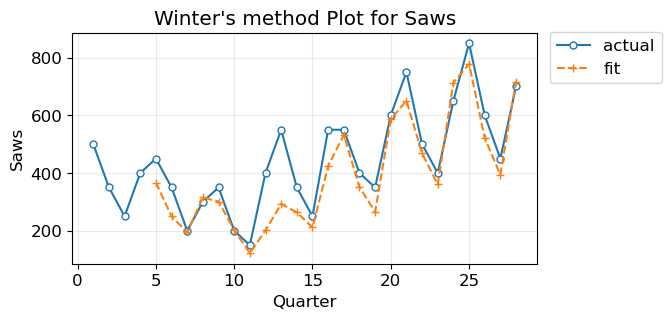

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

forecast_key = f"hat_Y_tP{p}"
ax.plot(df_forecast["t"], df_forecast[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label="fit")

ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Winter's method Plot for Saws")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


### Accuracy measures


In [20]:
MAPE, _ , MSE = get_accuracy_measures(df_forecast.iloc[:num_of_quarters+1], columns=["Y_t", f"hat_Y_tP{p}"])
print(f"(alpha, beta, gamma) = ({alpha}, {beta}, {gamma})")
print(f"  MSE   {MSE:>9,.0f} ")
print(f"  MAPE    {MAPE*100:>9.1f}%")


(alpha, beta, gamma) = (0.4, 0.1, 0.3)
  MSE       8,697 
  MAPE         16.1%


#### Autocorrelation function for Winter's method 

In [21]:
num_of_rk = 6 

df_winter = (df_forecast.iloc[:num_of_quarters+1]).copy()
df_winter = df_winter.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_winter, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.281034,1.256824,1.829017,-0.468014,0.468014
1,2,-0.076827,-0.319289,1.973299,-0.503624,0.503624
2,3,-0.033553,-0.138739,2.002438,-0.506184,0.506184
3,4,-0.139445,-0.576038,2.537173,-0.506671,0.506671
4,5,-0.316076,-1.284551,5.467694,-0.515009,0.515009
5,6,-0.091544,-0.344687,5.731075,-0.555877,0.555877


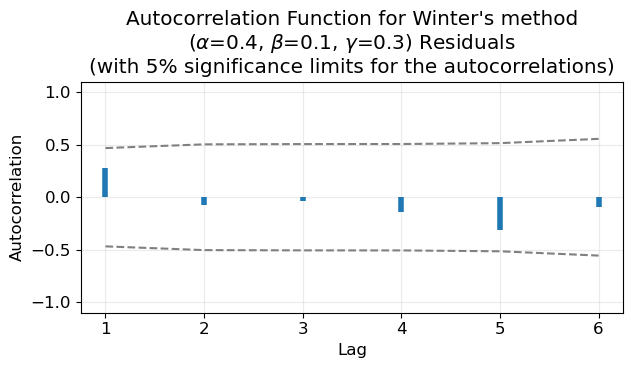

In [22]:
plot_autocorr_func(df_acorr_analysis, 
  title="Winter's method\n"r"($\alpha$=0.4, $\beta$=0.1, $\gamma$=0.3) Residuals")